## Setup and Load Data

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib pydot

In [2]:
import tensorflow as tf 
import os 
from matplotlib import pyplot as plt 
import numpy as np 
import pandas as pd 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle


In [3]:
# avoid OOM error by limiting GPU memory consumption 
gpus = tf. config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 

### Load Data

dataset from kaggle: https://www.kaggle.com/datasets/hasyimabdillah/workoutexercises-images/data

In [4]:
 #   for tf dataset pipeline documentation run this code, otherwise skip it 
 tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
@six.add_metaclass(abc.ABCMeta)
class DatasetV2(collections_abc.Iterable, tracking_base.Trackable,
                composite_tensor.CompositeTensor):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dtype=int32)
  tf.Ten

In [5]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export('keras.utils.image_dataset_from_directory',
              'keras.preprocessing.image_dataset_from_directory',
              v1=[])
def image_dataset_from_directory(directory,
                                 labels='inferred',
                                 label_mode='int',
                                 class_names=None,
                                 color_mode='rgb',
                                 batch_size=32,
                                 image_size=(256, 256),
                                 shuffle=True,
                                 seed=None,
               

In [6]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=16)

Found 13853 files belonging to 22 classes.


In [7]:
class_names= data.class_names
num_classes = len( class_names)

In [8]:
data_iterator = data.as_numpy_iterator() 
data_iterator

In [9]:
# images represented as numpy arrays in batches of 32 images (check documentation )
batch = data_iterator.next() 

In [10]:
#labels 
batch[1]

array([21,  9,  3, 17, 16, 20, 15,  2, 12,  5, 21,  8, 18, 15,  0, 21])

In [11]:
#number of batches 
len(data)

866

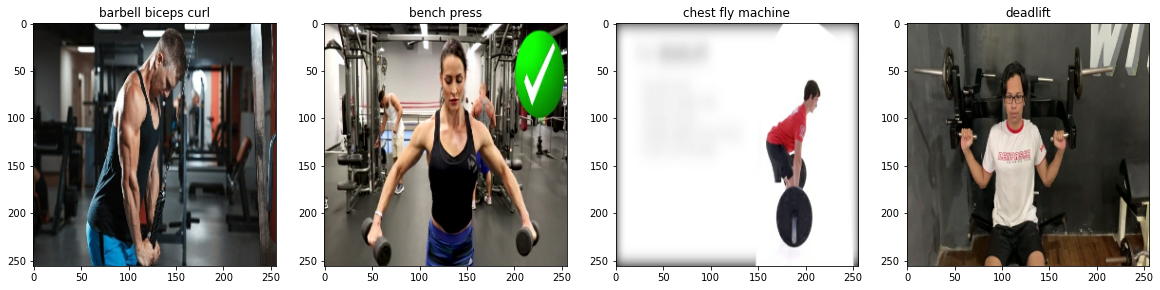

In [12]:
#check the some images of the batch with their respective class

fig, ax = plt.subplots(ncols=4, figsize = (20, 20))

for idx, img in enumerate (batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_names[idx])

## Preprocess data

#### scale data

In [13]:
scale_data = data.map(lambda x,y: (x/255, y))

scaled_iterator = scale_data.as_numpy_iterator()

batch = scaled_iterator.next()

#### split data

In [14]:
len(scale_data)

866

In [15]:
# 70 % for training , 20% for validation and 10% for testing 

train_size = int(len(scale_data)* .7)

val_size = int(len(scale_data)* .2)

test_size = int(len(scale_data)* .1) + 1

In [16]:
train = scale_data.take(train_size)

val = scale_data.skip(train_size).take(val_size)

test = scale_data.skip(train_size + val_size).take(test_size)

## Deep Learning 


#### Build Deep Learnig Model

In [17]:
#model dependencies 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 

In [18]:
model = Sequential()

####  Basic/first Arquitecture

Para el primer modelo de CNN que probamos nos basamos en lo que hay en el estado del arte para hacer la prueba control, para esto generamos un modelo secuencial teniendo: 


  - <b> input Layer: </b> la primera capa convolucional que recibe imágenes con una forma de 256x256 píxeles con 3 canales de color (RGB). Utiliza 16 filtros de tamaño 3x3 con un paso (stride) de 1 y la función de activación ReLU, después de la primera capa convolucional tenemos la primera capa de MaxPooling, esta capa reduce la dimensión espacial (ancho y alto) de la entrada a la mitad.


  - <b> bloques convolutivos: </b> Una segunda capa convolucional con 32 filtros. La entrada a esta capa es la salida de la capa de agrupamiento anterior, seguida de otra capa de MaxPooling, luego una tercera capa convolucional con 16 filtros que tambien sigue el parton de las capas anteriores seguida a su vez por otra capa de MaxPooling.


  - <b> Aplanamiento: </b> Esta capa convierte el mapa de características 3D resultante de las capas convolutivas y de MaxPooling en un vector de una sola dimension. 

  - <b> Capas Densa: </b> Una capa densa con 256 neuronas y función de activación ReLU.


  - <b> Output Layer: </b>  La última capa densa tiene un número de neuronas igual al número de clases que se quieren predecir (22 en nuestro caso). Utiliza la función de activación softmax, la cual es común para problemas de clasificación multiclase, ya que los valores de salida representarán las probabilidades de cada clase.

In [19]:
#convolution blocks 
#input layer
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

In [20]:
model.compile('adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
# Summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

###

### vizualizacion de la arquitectura del modelo

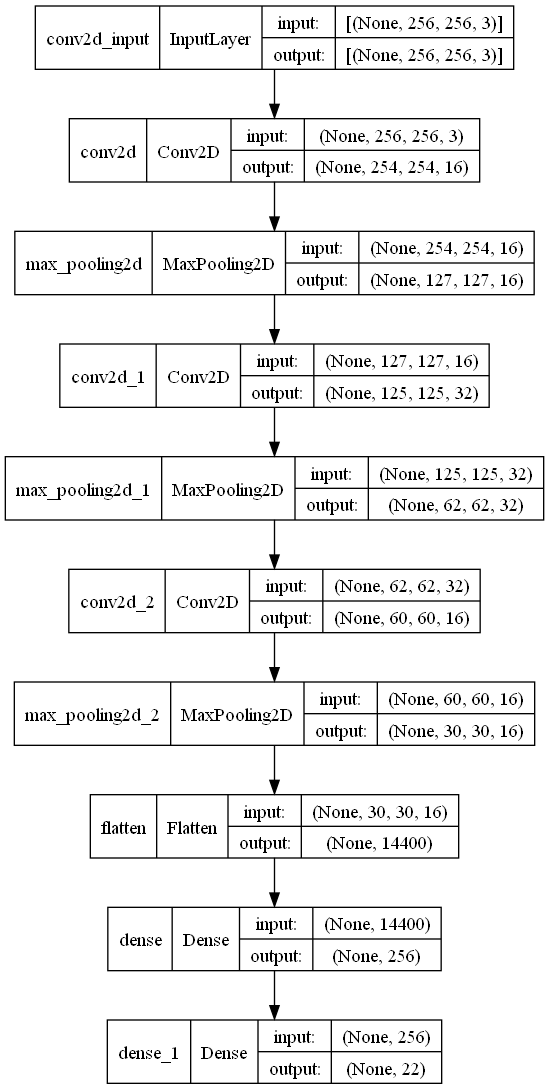

In [22]:
from tensorflow.keras.utils import plot_model

# Visualiza la arquitectura del modelo
directory = 'model architecture'
if not os.path.exists(directory):
    os.makedirs(directory)

plot_model(model, to_file=f'{directory}/controlModel.png', show_shapes=True)

# Este código guardará la imagen del modelo en el sistema de archivos

## Training the model

In [23]:
logDir = 'logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logDir)

In [24]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20


606/606 [==============================] - 24s 30ms/step - loss: 0.9417 - accuracy: 0.7577 - val_loss: 0.2911 - val_accuracy: 0.9440
Epoch 2/20
606/606 [==============================] - 18s 30ms/step - loss: 0.1028 - accuracy: 0.9747 - val_loss: 0.2765 - val_accuracy: 0.9480
Epoch 3/20
606/606 [==============================] - 21s 34ms/step - loss: 0.0415 - accuracy: 0.9888 - val_loss: 0.3440 - val_accuracy: 0.9454
Epoch 4/20
606/606 [==============================] - 20s 32ms/step - loss: 0.0347 - accuracy: 0.9908 - val_loss: 0.3201 - val_accuracy: 0.9552
Epoch 5/20
606/606 [==============================] - 19s 31ms/step - loss: 0.0569 - accuracy: 0.9865 - val_loss: 0.3591 - val_accuracy: 0.9512
Epoch 6/20
606/606 [==============================] - 19s 31ms/step - loss: 0.0174 - accuracy: 0.9957 - val_loss: 0.4297 - val_accuracy: 0.9433
Epoch 7/20
606/606 [==============================] - 19s 31ms/step - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.3858 - val_accuracy: 0.9570
Epo

### Cruvas de aprendisaje 

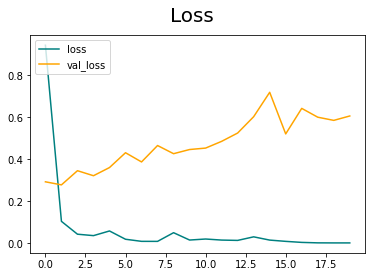

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

como podemos ver la funcion de perdida disminuye en gran medida, aunque en la validacion la curva es menos pronunciada y no disminuye, esto nos podria dar indicativos de un posible overfitting

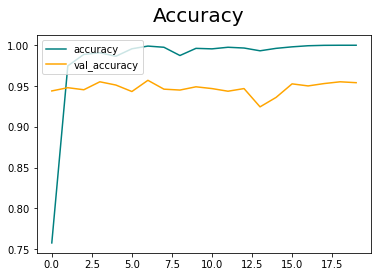

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Al vizualizar la curva de accuracy vemos algo similar, el modelo parece estar funcionando de manera correcta pero su accuracy es demasaido cercano al 1 lo que nos hace dudar sobre si el modelo realmente esta aprendiendo a generalizar sobre las images os implemente las esta memorizando

Accuracy: 0.9380849532037437
Precision: 0.9370287248474696
Recall: 0.9375049560615338


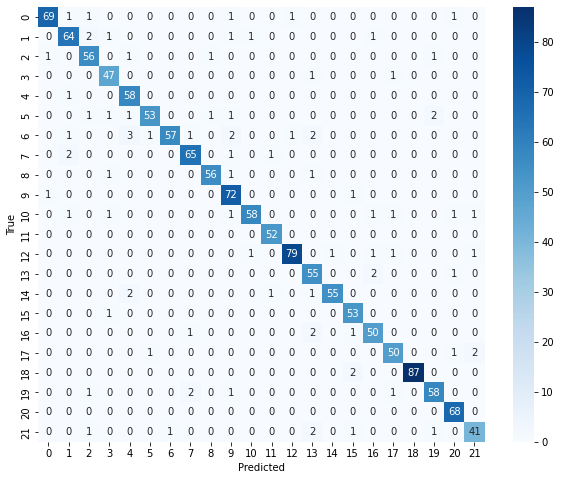

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    preds = model.predict(X)
    y_pred.extend(np.argmax(preds, axis=1))

# Calcula las métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # o 'micro' dependiendo de tu caso
recall = recall_score(y_true, y_pred, average='macro')  # o 'micro' dependiendo de tu caso

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Visualiza la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

finalmente vemos los resultados con una matriz de confusion, como se puede observar el modelo erra muy pocas veces alcanzando un Accuracy del 93%, una precision del 93% y un Recall del 93%, hay que tener en cuenta que el modelo tiene que clasficar entre 22 clases de ejercicios distintos y se necesitan mas pruebas para comprar que esto realmente esta funcionando bien 


### filtros convolutivos

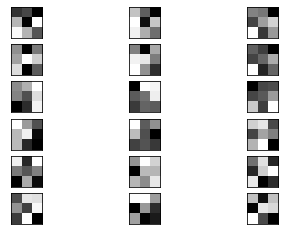

In [28]:
 # Para una capa convolucional específica
filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)  # Normalizar los filtros

# Visualizar los filtros
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):  
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
plt.show()

Ahora creo una funcion para generar distintos modelos para ir probando distintos hiperparametros, en esta parte a su vez vamos a agregar Data augmentation, lo hacemos agregando 4 capas a nuestro modelo:

- <b>Rescaling: </b> Esta capa reescala los valores de los píxeles de las imágenes.


- <b>RandomFlip: </b> Esta capa aplica un volteo horizontal aleatorio a las imágenes.


- <b>RandomRotation: </b> Esta capa rota las imágenes un número aleatorio de grados dentro de un rango especificado, en nuestro de caso de -36 a +36 grados.


- <b>RandomZoom: </b> Esta capa aplica un zoom aleatorio a las imágenes.


In [29]:
from tensorflow.keras import layers, models

def build_model(hp):
    model = models.Sequential()
    
    # Data augmentation
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
    model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.1))
    model.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.1))

    # Convolutional layers
    for i in range(hp['num_conv_layers']):
        model.add(layers.Conv2D(filters=hp['num_filters'][i], kernel_size=hp['kernel_size'][i], activation=hp['activation'], padding='same'))
        model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())

    # Dense layers at the end
    for i in range(hp['num_dense_layers']):
        model.add(layers.Dense(hp['num_dense_neurons'][i], activation=hp['activation']))

    # Output layer
    model.add(layers.Dense(22, activation='softmax'))  

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp['learning_rate'])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

Lista de hiperparametros a probar: (algunos fueron comentados por temas de memoria de mi pc local)

In [36]:
hp_examples = [
    {'num_conv_layers': 2, 'kernel_size': [(3, 3), (3, 3)], 'num_filters': [32, 64], 'activation': 'relu', 'num_dense_layers': 1, 'num_dense_neurons': [128], 'learning_rate': 0.001},
    {'num_conv_layers': 3, 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'num_filters': [32, 64, 128], 'activation': 'relu', 'num_dense_layers': 2, 'num_dense_neurons': [128, 64], 'learning_rate': 0.001},
    {'num_conv_layers': 4, 'kernel_size': [(5, 5), (5, 5), (3, 3), (3, 3)], 'num_filters': [32, 64, 128, 256], 'activation': 'relu', 'num_dense_layers': 2, 'num_dense_neurons': [256, 128], 'learning_rate': 0.0001},
    {'num_conv_layers': 2, 'kernel_size': [(3, 3), (3, 3)], 'num_filters': [64, 128], 'activation': 'sigmoid', 'num_dense_layers': 1, 'num_dense_neurons': [128], 'learning_rate': 0.01},
    {'num_conv_layers': 3, 'kernel_size': [(5, 5), (5, 5), (5, 5)], 'num_filters': [64, 128, 256], 'activation': 'relu', 'num_dense_layers': 2, 'num_dense_neurons': [256, 128], 'learning_rate': 0.001}]
#     {'num_conv_layers': 2, 'kernel_size': [(3, 3), (3, 3)], 'num_filters': [128, 256], 'activation': 'relu', 'num_dense_layers': 1, 'num_dense_neurons': [256], 'learning_rate': 0.0001},
#     {'num_conv_layers': 4, 'kernel_size': [(3, 3), (3, 3), (3, 3), (3, 3)], 'num_filters': [32, 64, 128, 256], 'activation': 'sigmoid', 'num_dense_layers': 2, 'num_dense_neurons': [128, 64], 'learning_rate': 0.01},
#     {'num_conv_layers': 3, 'kernel_size': [(5, 5), (5, 5), (5, 5)], 'num_filters': [32, 64, 128], 'activation': 'relu', 'num_dense_layers': 1, 'num_dense_neurons': [128], 'learning_rate': 0.001},
#     {'num_conv_layers': 2, 'kernel_size': [(5, 5), (5, 5)], 'num_filters': [64, 128], 'activation': 'sigmoid', 'num_dense_layers': 2, 'num_dense_neurons': [256, 128], 'learning_rate': 0.0001},
#     {'num_conv_layers': 4, 'kernel_size': [(3, 3), (3, 3), (5, 5), (5, 5)], 'num_filters': [32, 64, 128, 256], 'activation': 'relu', 'num_dense_layers': 2, 'num_dense_neurons': [256, 128], 'learning_rate': 0.001}
# ]

In [37]:
def train_and_evaluate_models(hp_list, train_data, val_data, epochs=10):
    best_accuracy = 0
    best_model = None
    best_hp = None
    best_history = None

    for hp in hp_list:
        # Build and compile the model
        model = build_model(hp)
        print(f"Training model with hyperparameters: {hp}")
        
        # Train the model
        history = model.fit(train_data, validation_data=val_data, epochs=epochs)
        
        # Evaluate the model
        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_hp = hp
            best_history = history
            print(f"New best model with val_accuracy: {val_accuracy}")

    return best_model, best_hp, best_history

In [38]:
best_model, best_hp, best_history = train_and_evaluate_models(hp_examples, train, val)

Training model with hyperparameters: {'num_conv_layers': 2, 'kernel_size': [(3, 3), (3, 3)], 'num_filters': [32, 64], 'activation': 'relu', 'num_dense_layers': 1, 'num_dense_neurons': [128], 'learning_rate': 0.001}
Epoch 1/10
606/606 [==============================] - 26s 42ms/step - loss: 3.0835 - accuracy: 0.0689 - val_loss: 3.0743 - val_accuracy: 0.0853
Epoch 2/10
606/606 [==============================] - 26s 42ms/step - loss: 3.0758 - accuracy: 0.0689 - val_loss: 3.0719 - val_accuracy: 0.0863
Epoch 3/10
606/606 [==============================] - 25s 41ms/step - loss: 3.0753 - accuracy: 0.0692 - val_loss: 3.0723 - val_accuracy: 0.0856
Epoch 4/10
606/606 [==============================] - 25s 41ms/step - loss: 3.0754 - accuracy: 0.0693 - val_loss: 3.0731 - val_accuracy: 0.0856
Epoch 5/10
606/606 [==============================] - 28s 46ms/step - loss: 3.0753 - accuracy: 0.0691 - val_loss: 3.0717 - val_accuracy: 0.0871
Epoch 6/10
606/606 [==============================] - 27s 44ms/st

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_data):
    # Assuming test_data is a tf.data.Dataset
    test_images, test_labels = next(iter(test_data.unbatch().batch(len(test_data))))
    
    # Get the model predictions
    predictions = model.predict(test_images)
    predictions = np.argmax(predictions, axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, predictions)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:

plot_learning_curves(best_history)


plot_confusion_matrix(best_model, test)